# Cell Analysis Deep

- How does Layer Size impact complex patterns (Not much at all, just smaller oscillations but same patterns. Only depth helps)
- How does Regularization impact complex patterns




In [ ]:
! pip install seaborn
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, TimeDistributed, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D, Layer
from sklearn.preprocessing import MinMaxScaler

import torch
import sympy
import seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# Get the current working directory (where your notebook is)
current_directory = os.getcwd()

# Construct the full path to your data_utils.py file
data_utils_path = '/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Thesis Files/data_utils.py'  # Replace with the actual path

# Add the directory containing data_utils.py to the Python path
sys.path.append(os.path.dirname(data_utils_path))  # Add parent directory of data_utils.py

# Now you can import the custom module
import data_utils as du
import analysis_utils as au

sys.path = []

In [ ]:
# ONLY FOR RELOAD!

# Reloads if the data_utils has been updated during runtime
# Always need to add and reset the paths
import importlib

data_utils_path = '/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Thesis Files/data_utils.py'  # Replace with the actual path

# Add the directory containing data_utils.py to the Python path
sys.path.append(os.path.dirname(data_utils_path))  # Add parent directory of data_utils.py

importlib.reload(du)  # This reloads the module
importlib.reload(au)  # This reloads the module

sys.path = []

### Data Loading and Preprocessing

In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/Including Features/5_class_mid_noise_30s_features_vec.npy"
label_path = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/Including Features/5_class_mid_noise_30s_numeric_label_vec.npy"

data_vec, label_vec = du.load_data(data_path, label_path)

du.data_info(data_vec)

DATASET INFO:
Shape: (10, 20, 5, 7500, 25)

No of Samples: 10

No of Frequencies: 20
Freqency values: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(11), np.int64(13), np.int64(16), np.int64(18), np.int64(22), np.int64(26), np.int64(31), np.int64(36), np.int64(43), np.int64(51), np.int64(60), np.int64(71), np.int64(84), np.int64(100)]

No of noise ratios: 5
Signal to Noise ratios (in db) [np.int64(-10), np.int64(-8), np.int64(-6), np.int64(-4), np.int64(-2), np.int64(0), np.int64(2), np.int64(4), np.int64(6), np.int64(8)]

No of Datapoints: 7500

No of Features per Datapoint: 25 (signal, hilbert amp, 20 wavelets for each freq)


In [ ]:
data_vec.shape

(10, 20, 5, 7500, 25)

In [ ]:
beta_data_vec = data_vec[:7,10:15, 1:4]
beta_label_vec = label_vec[:7,10:15, 1:4]

beta_data_vec, beta_label_vec = du.preprocess_data(beta_data_vec, beta_label_vec)

print(beta_data_vec.shape)
print(beta_label_vec.shape)

(105, 7500, 25)
(105, 7500, 1)


## Create Train-Test-Split w/ Shuffled Sample

Currently an absolute mess!
Both Train and Testing must include all oscillation types, but since we have only 2 alpha sets per 20 set sample, it can be difficult.

Currently running on a 75/25 train-test split

Also class weights are awful.

We easily converge to just saying no burst detection and get 85% accuracy.
This sucks.

In [ ]:
X = beta_data_vec[:,:,:1]
y = beta_label_vec[:,:]

y_binary = y.copy()
y_binary[y_binary >= 1] = 1  # Convert to binary labels

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_test.shape)

NameError: name 'beta_data_vec' is not defined

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Assuming X_train and X_test have shape (120, 7500, 1)

# 1. Reshape to 2D for scaling
X_train_2D = X_train.reshape(-1, 1)
X_test_2D = X_test.reshape(-1, 1)

print(X_train_2D.shape)
print(X_test_2D.shape)

# 2. Create and fit the scaler
scaler = MinMaxScaler(feature_range=(-4, 4))
scaler.fit(X_train_2D)

# 3. Transform the data
X_train_scaled_2D = scaler.transform(X_train_2D)
X_test_scaled_2D = scaler.transform(X_test_2D)

# 4. Reshape back to 3D
X_train_scaled = X_train_scaled_2D.reshape(X_train.shape)
X_test_scaled = X_test_scaled_2D.reshape(X_test.shape)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(630000, 1)
(157500, 1)
(84, 7500, 1)
(21, 7500, 1)


In [ ]:
# Saves the Train/Test Splits
# VERY IMPORTANT FOR THIS TO MAKE SENSE
splits_dict = {
    'X_train': X_train_scaled,
    'X_test': X_test_scaled,
    'y_train': y_train,
    'y_test': y_test
}

baseSplitsPath = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Cell State Analysis/Data Splits/"
du.save_splits_dict(splits_dict, f'{baseSplitsPath}signal_only_new.pkl')

Splits dictionary saved to: /content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Cell State Analysis/Data Splits/signal_only_new.pkl


### Train/Test Data Visualization

(Can be skipped)

In [ ]:
label_map = {'n': 0, 't': 1, 'a': 2, 'b': 3, 'g': 4}

In [ ]:
## Train Split class distribution
unique, counts = np.unique(y_test, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")
print(f"Noise  Percentage: {(counts[0]/(sum(counts))):.4f}")
print(f"Burst Percentage: {(counts[1]/(sum(counts))):.4f}")

Class distribution: {np.int64(0): np.int64(82221), np.int64(1): np.int64(75279)}
Noise  Percentage: 0.5220
Burst Percentage: 0.4780


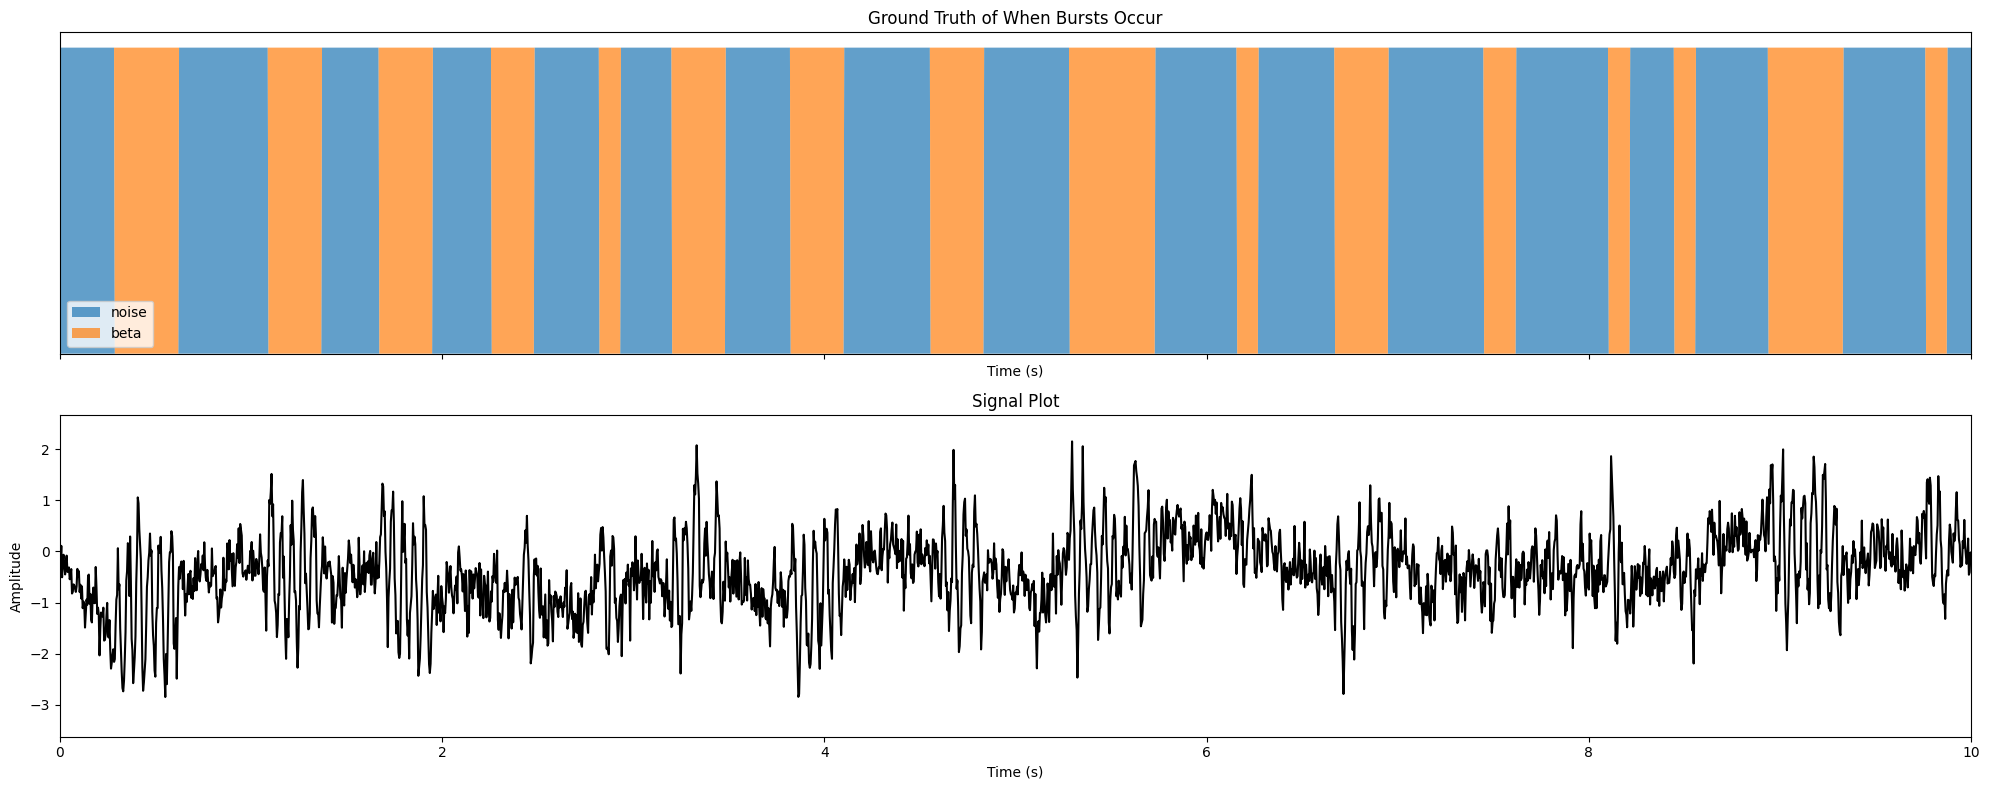

In [ ]:
# Use IF we DO NOT have FEATURES
sample_number = 1

label_sample_low = y_train[sample_number].flatten()
signal_sample_low = X_train_scaled[sample_number].flatten()

du.visualize_training_data(label_sample_low, signal_sample_low, duration=30)

In [ ]:
# # Use IF we have FEATURES
#  # (if seq_len !=15000 set the duration or freq attribute of the function accordingly)

# sample_number = 4
# label_sample_high = y_test_all[sample_number].flatten()
# signal_sample_high = X_test_all[sample_number,:,0].flatten()
# feature_sample_high = X_test_all[sample_number,:,1:15]

# print(feature_sample_high.shape)

# # Define category labels (adjust if you have different categories)
# category_labels = ['noise', 'theta', 'alpha', 'beta', 'gamma']

# # Call visualize_feature_data with the category_labels argument
# du.visualize_feature_data(label_sample_high, signal_sample_high, feature_sample_high, duration=30, category_labels=category_labels)

## LSTM Architecture

### Own LSTM Cell (Important)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTMCell, Input, RNN, Dense, Bidirectional
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.saving import register_keras_serializable  # Import register_keras_serializable


@register_keras_serializable()  # Add this decorator
class LSTMCellReturnCellState(LSTMCell):
    def call(self, inputs, states, training=None):
        real_inputs = inputs
        outputs, [h, c] = super().call(real_inputs, states, training=training)

        kernel = self.kernel
        recurrent_kernel = self.recurrent_kernel
        bias = self.bias

        # Reshape kernel for compatibility with input shape
        kernel = tf.reshape(kernel, (inputs.shape[-1], 4 * self.units))
        recurrent_kernel = tf.reshape(recurrent_kernel, (self.units, 4 * self.units))

        # Input gate
        input_gate = tf.sigmoid(tf.matmul(real_inputs, kernel[:, :self.units]) + tf.matmul(h, recurrent_kernel[:, :self.units]) + bias[:self.units])
        # Forget Gate
        forget_gate = tf.sigmoid(tf.matmul(real_inputs, kernel[:, self.units:2*self.units]) + tf.matmul(h, recurrent_kernel[:, self.units:2*self.units]) + bias[self.units:2*self.units])
        # Cell Update Gate
        cell_update_gate = tf.tanh(tf.matmul(real_inputs, kernel[:, 2*self.units:3*self.units]) + tf.matmul(h, recurrent_kernel[:, 2*self.units:3*self.units]) + bias[2*self.units:3*self.units])
        # Output Gate
        output_gate = tf.sigmoid(tf.matmul(real_inputs, kernel[:, 3*self.units:]) + tf.matmul(h, recurrent_kernel[:, 3*self.units:]) + bias[3*self.units:])

        # Return the concatenated output and the states
        # Change return values if you want more
        return tf.concat([outputs, h, c, input_gate, forget_gate, cell_update_gate, output_gate], axis=1), [h, c]

# Create an instance of the custom cell outside the create_model function
custom_cell_all_gates = LSTMCellReturnCellState(32)  # Replace 32 with your desired number of units

@register_keras_serializable()  # Add this decorator
class LSTMCellReturnCellStateOnly(LSTMCell):
    def call(self, inputs, states, training=None):
        real_inputs = inputs
        outputs, [h, c] = super().call(real_inputs, states, training=training)

        # Return the concatenated output and the states
        # Change return values if you want more
        return tf.concat([outputs, h, c], axis=1), [h, c]

custom_cell = LSTMCellReturnCellStateOnly(32)  # Replace 32 with your desired number of units

# Create an instance of the custom cell outside the create_model function
custom_cell = LSTMCellReturnCellState(32)  # Replace 32 with your desired number of units

def create_model_all_gates(input_shape=(7500, 1), num_units=32):
    """Creates and compiles the LSTM model with cell state extraction.

    Args:
        input_shape: Tuple, the shape of the input data.
        num_units: Int, the number of LSTM units.

    Returns:
        A compiled Keras model.
    """
    # Input layer
    inputs = Input(shape=input_shape)

    # Bidirectional LSTM layer as the first hidden layer
    # first_lstm_layer = LSTM(32, return_sequences=True)(inputs)


    # LSTM layer with modified cells
    lstm_layer = RNN(LSTMCellReturnCellState(num_units),
                      name='lstm_analyis_layer',
                      return_sequences=True,
                      return_state=True)

    whole_seq_output, final_memory_state, final_carry_state = lstm_layer(inputs)

    # Extract hidden state, cell state, gates, and output
    outputs = whole_seq_output[:, :, :num_units]  # Output of LSTM cell
    h_seq = whole_seq_output[:, :, num_units:2 * num_units]  # Hidden state (h)
    c_seq = whole_seq_output[:, :, 2 * num_units:3 * num_units]  # Cell state (c)
    input_gate = whole_seq_output[:, :, 3 * num_units:4 * num_units] # Input gate (i)
    forget_gate = whole_seq_output[:, :, 4 * num_units:5 * num_units] # Forget gate (f)
    cell_update_gate = whole_seq_output[:, :, 5 * num_units:6 * num_units] # Cell update gate (c)
    output_gate = whole_seq_output[:, :, 6 * num_units:] # Output gate (o)

    # Output layer (e.g., binary classification)
    output_layer = Dense(1, activation='sigmoid')(outputs)

    # Create the model
    # Change outputs of model
    model = Model(inputs=inputs, outputs=[output_layer, h_seq, c_seq, input_gate, forget_gate, cell_update_gate, output_gate])

    # Compile the model
    model.compile(optimizer='adam',
                  loss=['binary_crossentropy', 'mse', 'mse', 'mse', 'mse', 'mse', 'mse'],
                  loss_weights=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                  metrics=[['accuracy'], [], [], [], [], [], []])
    return model

def create_model_hidden_cell(input_shape=(7500, 1), num_units=32):
    """Creates and compiles the LSTM model with cell state extraction.

    Args:
        input_shape: Tuple, the shape of the input data.
        num_units: Int, the number of LSTM units.

    Returns:
        A compiled Keras model.
    """
    # Input layer
    inputs = Input(shape=input_shape)

    # Bidirectional LSTM layer as the first hidden layer
    # bi_lstm_layer = LSTM(64, return_sequences=True)(inputs)


    # LSTM layer with modified cells
    lstm_layer = Bidirectional(RNN(LSTMCellReturnCellStateOnly(num_units),
                      return_sequences=True,
                      return_state=True))

    whole_seq_output, final_memory_state, final_carry_state = lstm_layer(inputs)

    # Extract hidden state, cell state, gates, and output
    outputs = whole_seq_output[:, :, :num_units]  # Output of LSTM cell
    h_seq = whole_seq_output[:, :, num_units:2 * num_units]  # Hidden state (h)
    c_seq = whole_seq_output[:, :, 2 * num_units:3 * num_units]  # Cell state (c)

    # Output layer (e.g., binary classification)
    output_layer = Dense(1, activation='sigmoid')(outputs)

    # Create the model
    # Change outputs of model
    model = Model(inputs=inputs, outputs=[output_layer, h_seq, c_seq])

    # Compile the model
    model.compile(optimizer='adam',
                  loss=['binary_crossentropy', 'mse', 'mse'],
                  loss_weights=[1.0, 0.0, 0.0],
                  metrics=[['accuracy'], [], []])


    return model

class OutputTracker(tf.keras.callbacks.Callback):
    def __init__(self):
        super(OutputTracker, self).__init__()
        self.epoch_outputs = []  # List to store all outputs per epoch
        self.saved_models = []

    def on_epoch_end(self, epoch, logs=None):
        # Assuming your model outputs are:
        # [output_layer, h_seq, c_seq, input_gate, forget_gate, cell_update_gate, output_gate]

        # 1. Get outputs for a batch of data (e.g., X_train_scaled)
        outputs = self.model.predict(X_test_scaled[:3])

        # 2. Store outputs for this epoch
        self.epoch_outputs.append(outputs)

        model_copy = tf.keras.models.clone_model(self.model)
        model_copy.set_weights(self.model.get_weights())
        self.saved_models.append((epoch, model_copy))  # Save as (epoch, model) pair
        print(f"Model saved at epoch {epoch + 1}")



**Things to try out**

- MinMaxScaler -> (Scaling higher better, lower worse)
- Deeper Layer
- BiDirectional LSTM
- Regularization
- Pre Set Weights and slower learning alpha
- Bigger Batch_size? Longer epochs

In [ ]:
y_train.shape

(84, 7500, 1)

## Model Training

In [ ]:
# --- Usage ---
model = create_model_all_gates((7500,1), num_units=32)  # Create an instance of the model

output_tracker = OutputTracker()

# Train the model with the callback
model.fit(X_train_scaled, [y_train, y_train, y_train, y_train, y_train, y_train, y_train],
          batch_size=16,
          validation_data=(X_test_scaled, [y_test,y_test,y_test,y_test,y_test,y_test, y_test]),
          epochs=20,
          verbose=1,
          callbacks=[output_tracker])

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
Model saved at epoch 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - dense_accuracy: 0.4265 - dense_loss: 0.7167 - get_item_1_loss: 0.4694 - get_item_2_loss: 0.4814 - get_item_3_loss: 0.2504 - get_item_4_loss: 0.3138 - get_item_5_loss: 0.4768 - get_item_6_loss: 0.2509 - loss: 0.7170 - val_dense_accuracy: 0.4307 - val_dense_loss: 0.7069 - val_get_item_1_loss: 0.4751 - val_get_item_2_loss: 0.4883 - val_get_item_3_loss: 0.2503 - val_get_item_4_loss: 0.3123 - val_get_item_5_loss: 0.4825 - val_get_item_6_loss: 0.2509 - val_loss: 0.7057
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Model saved at epoch 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 983ms/step - dense_accuracy: 0.4418 - dense_loss: 0.7035 - get_item_1_loss: 0.4751 - get_item_2_loss: 0.4890 - get_item_3_loss: 0.2503 - get_item_4_loss: 0.3128 - get_item_5_loss: 0.4824 - get_item_6_loss: 0.2509 - loss: 0.7036 - val_dense_accuracy: 0.5055 - val_dense_loss: 0.6971 - val_get_item_1_loss: 0.4799 - val_ge

In [ ]:
def extract_feature_data_all_epochs(all_epoch_outputs):
  """Extracts data for a single sample across all epochs."""
  num_epochs = len(all_epoch_outputs)

  # Initialize empty lists to store data for each feature across epochs
  output_layers = []
  hidden_states = []
  cell_states = []
  input_gates = []
  forget_gates = []
  cell_update_gates = []
  output_gates = []

  # Iterate over epochs to extract data for the specific sample:
  for epoch_data in all_epoch_outputs:
      # Unpack the prediction details for the current epoch
      output_layer, h_seq, c_seq, i_gate, f_gate, cu_gate, o_gate = epoch_data

      output_layers.append(output_layer)  # Append output layer for the sample
      hidden_states.append(h_seq)  # Append hidden states for the sample
      cell_states.append(c_seq)       # Append cell states for the sample
      input_gates.append(i_gate)     # Append input gates for the sample
      forget_gates.append(f_gate)     # Append forget gates for the sample
      cell_update_gates.append(cu_gate)  # Append cell update gates for the sample
      output_gates.append(o_gate)  # Append output gates for the sample

  # Convert to NumPy arrays for easier plotting
  output_layers = np.array(output_layers)
  hidden_states = np.array(hidden_states)
  cell_states = np.array(cell_states)
  input_gates = np.array(input_gates)
  forget_gates = np.array(forget_gates)
  cell_update_gates = np.array(cell_update_gates)
  output_gates = np.array(output_gates)

  return {
      'outputs': output_layers,
      'hidden_states': hidden_states,
      'cell_states': cell_states,
      'input_gates': input_gates,
      'forget_gates': forget_gates,
      'cell_update_gates': cell_update_gates,
      'output_gates': output_gates,
  }

In [ ]:
feature_data_all_epochs = extract_feature_data_all_epochs(output_tracker.epoch_outputs)

In [ ]:
import pickle
basePath = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Cell State Analysis/Models/"

modelPath = f"{basePath}/SimpleLSTM-AllHiddenData.keras"
model.save(modelPath)

with open(f'{basePath}SimpleLSTM-AllHiddenData.pkl', 'wb') as f:
    pickle.dump(feature_data_all_epochs, f)

## Model Analysis

In [ ]:
from tensorflow.keras.saving import register_keras_serializable  # Import register_keras_serializable
import pickle

# Load Model
basePath = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Cell State Analysis/Models/"

modelPath = f"{basePath}/SimpleLSTM-AllHiddenData.keras"
# model = tf.keras.models.load_model(modelPath, custom_objects={'LSTMCellReturnCellState': LSTMCellReturnCellState})
model = tf.keras.models.load_model(modelPath)


# Load Epoch Analysis Dictionary
with open(f'{basePath}/SimpleLSTM-AllHiddenData.pkl', 'rb') as f:
    feature_data_all_epochs = pickle.load(f)

# Load Epoch Analysis Dictionary
with open(f'{basePath}/../Data Splits/signal_only_new.pkl', 'rb') as f:
    train_test_splits = pickle.load(f)

In [ ]:
print(feature_data_all_epochs.keys()) # Output Tracker saves only first 3 samples of testing set
print(train_test_splits.keys())
print(train_test_splits["X_test"].shape)
feature_data_all_epochs['hidden_states'].shape

dict_keys(['outputs', 'hidden_states', 'cell_states', 'input_gates', 'forget_gates', 'cell_update_gates', 'output_gates'])
dict_keys(['X_train', 'X_test', 'y_train', 'y_test'])
(21, 7500, 1)


(20, 3, 7500, 32)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def visualize_feature_evolution(feature_data_all_epochs, label_sample, signal_sample, sample_index, num_epochs, cell_index=0, time_window=(0, 3), sampling_frequency=250, duration=30):
    """
    Visualizes the evolution of multiple LSTM features over epochs.

    Args:
        feature_data_all_epochs (dict): Dictionary containing feature data for all epochs.
        label_sample (np.ndarray): 1D array of ground truth labels for the sample.
        signal_sample (np.ndarray): 1D array of signal data for the sample.
        sample_index (int): Index of the sample to plot.
        num_epochs (int): Number of epochs in the training.
        cell_index (int, optional): Index of the LSTM cell to analyze (default: 0).
        time_window (tuple, optional): Time window to display in seconds (start, end) (default: (0, 3)).
        sampling_frequency (int, optional): Sampling frequency of the data (default: 250).
        duration (int, optional): Duration of the data in seconds (default: 30).
    """
    label_size = 18
    time_vec = np.linspace(0, duration, duration * sampling_frequency, endpoint=False)

    # Create subplots for each feature + 1 for signal + 1 for ground truth
    num_features = len(feature_data_all_epochs)
    fig, axes = plt.subplots(num_features + 1, 1, figsize=(20, 3.5 * (num_features + 1)), sharex=True)

    # Choose a colormap (e.g., 'viridis')
    colormap = cm.get_cmap('viridis', num_epochs)
    colormap = colormap.reversed()  # Reverse the colormap
    # Plot the signal sample on the first axis (axes[0])
    axes[0].plot(time_vec, signal_sample, color='black')
    max_value = np.max(signal_sample)
    min_value = np.min(signal_sample)
    print(max_value)
    print(min_value)
    axes[0].stackplot(time_vec, label_sample*max_value, labels=["Ground Truth"], alpha=0.7, colors=['lightblue'])
    axes[0].stackplot(time_vec, label_sample*min_value, alpha=0.7, colors=['lightblue'])
    axes[0].set_title('Signal Sample', fontsize =label_size)
    axes[0].set_ylabel('Amplitude', fontsize =label_size)
    axes[0].set_ylim((min_value, max_value))  # Adjust x-axis limits


    ax_headings = ['Model Prediction', 'Hidden State',  'Output Gate', 'Cell State','Forget Gate', 'Input Gate', 'Cell Update Gate', ]

    # Iterate through each feature and plot on its respective axis (starting from axes[2])
    for i, (feature_name, feature_data) in enumerate(feature_data_all_epochs.items()):
        ax = axes[i + 1]  # Get the axis for the current feature (shifted by 2)

        print(feature_name)

        # Special case for 'outputs'
        if feature_name == 'outputs':
            max_value = np.max(feature_data[:, sample_index, :])
            min_value = np.min(feature_data[:, sample_index, :])

            ax.axhline(y=0.5, color='red', linestyle='-', label="Threshold", alpha=0.4)

            ax.stackplot(time_vec, label_sample*max_value, labels=["Ground Truth"], alpha=0.7, colors=['lightblue'])
            ax.stackplot(time_vec, label_sample*min_value, alpha=0.7, colors=['lightblue'])
            ax.set_ylabel('Model Confidence', fontsize =label_size)
            for epoch_index in range(0, num_epochs + 1, 2):
                color = colormap(epoch_index)  # Get color for the current epoch
                ax.plot(time_vec, feature_data[epoch_index - 1, sample_index, :],
                        label=f'Epoch {epoch_index}', alpha=0.7, color=color)

                ax.set_xlabel("Time (s)", fontsize =label_size)
                ax.set_title("Model Prediction", fontsize =label_size)
                ax.set_xlim(time_window)
                ax.set_ylim(min_value, max_value)
        else:
            max_value = np.max(feature_data[:, sample_index, :, cell_index])
            min_value = np.min(feature_data[:, sample_index, :, cell_index])


            ax.stackplot(time_vec, label_sample*max_value, labels=["Ground Truth"], alpha=0.7, colors=['lightblue'])
            ax.stackplot(time_vec, label_sample*min_value, alpha=0.7, colors=['lightblue'])

            # Plot data for each epoch in a separate color
            for epoch_index in range(0, num_epochs + 1, 2):
                color = colormap(epoch_index)  # Get color for the current epoch

                # Plot the data for the current epoch
                ax.plot(time_vec, feature_data[epoch_index - 1, sample_index, :, cell_index],
                        label=f'Epoch {epoch_index}', alpha=0.7, color=color)
                ax.set_xlabel("Time (s)", fontsize =label_size)
                ax.set_xlim(time_window)
                ax.set_ylim(min_value, max_value)

            ax.set_title(f'{ax_headings[i]} - Cell {cell_index + 1}', fontsize =label_size)
            ax.set_ylabel('Value', fontsize =label_size)

        ax.set_xlabel('Time (s)', fontsize =label_size)

        # Position the legend on the far right
        ax.legend(loc='lower right', ncol=3 )
        ax.set_xlim(time_window)  # Adjust x-axis limits

    plt.tight_layout()
    plt.show()

In [ ]:
feature_data_all_epochs["input_gates"].shape


(20, 3, 7500, 32)

In [ ]:
feature_data_all_epochs["cell_update_gates"].shape

(20, 3, 7500, 32)

In [ ]:
# Calculate and plot the combined gate data
input_gate_data = feature_data_all_epochs['input_gates']
cell_update_data = feature_data_all_epochs['cell_update_gates']
cell_state_data = feature_data_all_epochs['cell_states']
forget_gate_data = feature_data_all_epochs['forget_gates']
output_gate_data = feature_data_all_epochs['output_gates']


combined_gate_data = input_gate_data * cell_update_data  # Element-wise multiplication

feature_data_all_epochs["all_update_gates"] = combined_gate_data

feature_data_all_epochs["forget_cell_state"] = cell_state_data * forget_gate_data
feature_data_all_epochs["new_cell_state"] = combined_gate_data + cell_state_data * forget_gate_data

feature_data_all_epochs["new_hidden_state"] = output_gate_data * np.tanh(cell_state_data)

In [ ]:
train_test_splits["y_test"].shape

(21, 7500, 1)

In [ ]:
cell_state_data.shape

(20, 3, 7500, 32)

In [ ]:
label_sample.sha
np.corrcoef(label_sample, cell_state_data)

ValueError: y has more than 2 dimensions

In [ ]:
# Assuming feature_data_all_epochs is your original dictionary

# Define the desired order of keys
desired_order = ['outputs', 'hidden_states', 'output_gates', 'cell_states', 'forget_gates', 'input_gates', 'cell_update_gates']

# Create a new dictionary with the desired order
reordered_feature_data = {key: feature_data_all_epochs[key] for key in desired_order}

# Now, reordered_feature_data will have the key-value pairs in the specified order

In [ ]:
reordered_feature_data.keys()

dict_keys(['outputs', 'hidden_states', 'output_gates', 'cell_states', 'forget_gates', 'input_gates', 'cell_update_gates'])

In [ ]:
# 1. Extract data for a specific sample
sample_index = 0  # Choose the sample to analyze
cell_index = 19  # Choose the cell to analyze
signal_sample  = train_test_splits["X_test"][sample_index,:,0].flatten()
label_sample  = train_test_splits["y_test"][sample_index].flatten()

# 2. Visualize the evolution of a specific feature (e.g., hidden_states)
num_epochs = len(feature_data_all_epochs["outputs"])
print(num_epochs)
visualize_feature_evolution(reordered_feature_data, label_sample, signal_sample, sample_index, num_epochs=20, cell_index=cell_index)

# Repeat step 2 for other features (cell_states, input_gates, forget_gates, cell_update_gates, output_gates)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import numpy as np
from sklearn.metrics import matthews_corrcoef  # Import MCC function

def extract_prediction_details(model, X_test, y_test):
    """
    Extracts hidden state, cell state, gates, and output prediction from the model.

    Args:
        model: The trained Keras model.
        X_test: The input data for prediction.

    Returns:
        tuple: A tuple containing the output prediction, hidden states, cell states,
               input gate values, forget gate values, cell update gate values,
               and output gate values.
    """

    # Make predictions and extract all outputs
    prediction_details = model.predict(X_test)



    # Unpack the prediction details
    output_predictions, h_seq, c_seq, input_gate, forget_gate, cell_update_gate, output_gate = prediction_details

    # 2. Calculate accuracy (assuming binary classification)
    predicted_labels = (output_predictions > 0.5).astype(int)  # Threshold predictions for binary classification
    accuracy = np.mean(predicted_labels == y_test)

    return accuracy, output_predictions, h_seq, c_seq, input_gate, forget_gate, cell_update_gate, output_gate

# --- Usage ---
# Assuming you have your trained model and X_test data
accuracy, output_prediction, hidden_states, cell_states, input_gates, forget_gates, cell_update_gates, output_gates = extract_prediction_details(model, train_test_splits["X_test"],  train_test_splits["y_test"])

# Now you have access to all the extracted information:
print(f"Accuracy on Testing Set: {accuracy:.4f}")
print("Output Prediction Shape:", output_prediction.shape)
print("Hidden States Shape:", hidden_states.shape)
print("Cell States Shape:", cell_states.shape)
print("Input Gates Shape:", input_gates.shape)
print("Forget Gates Shape:", forget_gates.shape)
print("Cell Update Gates Shape:", cell_update_gates.shape)
print("Output Gates Shape:", output_gates.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Accuracy on Testing Set: 0.8267
Output Prediction Shape: (21, 7500, 1)
Hidden States Shape: (21, 7500, 32)
Cell States Shape: (21, 7500, 32)
Input Gates Shape: (21, 7500, 32)
Forget Gates Shape: (21, 7500, 32)
Cell Update Gates Shape: (21, 7500, 32)
Output Gates Shape: (21, 7500, 32)


In [ ]:
output_prediction_binary = (output_prediction >= 0.5).astype(int)
output_prediction_binary.shape

(21, 7500, 1)

In [ ]:
cell_states.shape

(21, 7500, 32)

(7500,)
(7500,)
(7500, 6)


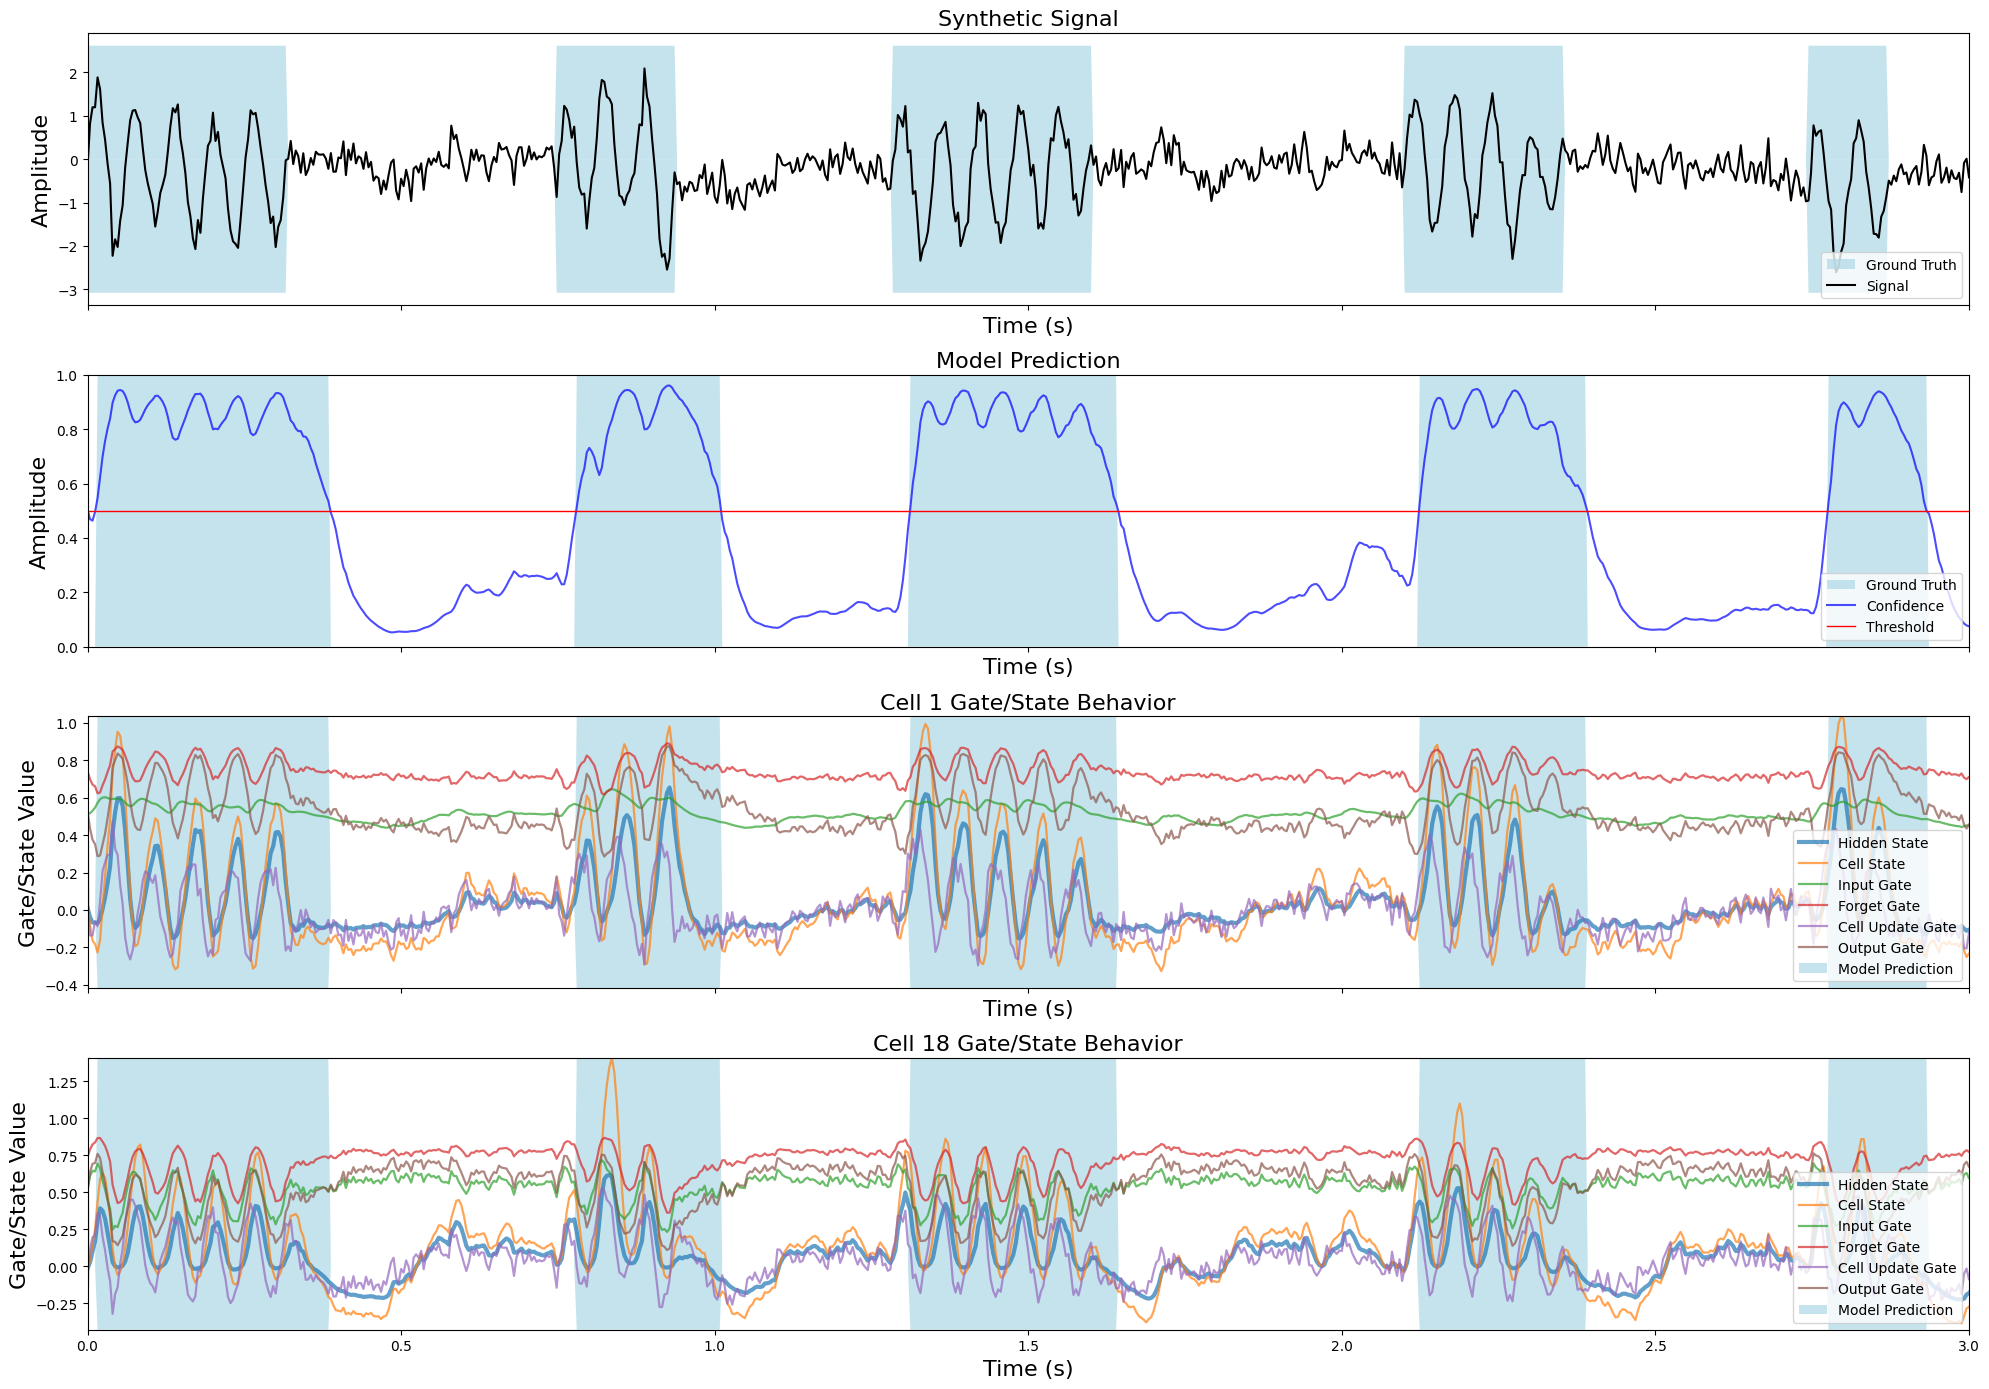

In [ ]:
sample = 1
cell_id = 2
cell_id2 = 17

X_test_scaled =  train_test_splits["X_test"]
y_test =  train_test_splits["y_test"]

label_sample = y_test[sample].flatten()
signal_sample = X_test_scaled[sample,:,0].flatten()
wavelet_sample = cell_states[sample,:,:2]
wavelet_sample2 = cell_states[sample,:,4:5]

output_prediction_sample = output_prediction[sample, :, 0].flatten()
wavelet_sample = np.stack([hidden_states[sample,:,cell_id],
                          cell_states[sample,:,cell_id],
                          input_gates[sample,:,cell_id],
                          forget_gates[sample,:,cell_id],
                          cell_update_gates[sample,:,cell_id],
                          output_gates[sample,:,cell_id]], axis=1)

# Creating an array with the same shape as wavelet_sample
wavelet_sample2 = np.stack([hidden_states[sample,:,cell_id2], # Changed index to 4
                              cell_states[sample,:,cell_id2], # Changed index to 4
                              input_gates[sample,:,cell_id2], # Changed index to 4
                              forget_gates[sample,:,cell_id2], # Changed index to 4
                              cell_update_gates[sample,:,cell_id2], # Changed index to 4
                              output_gates[sample,:,cell_id2]], axis=1) # Changed index to 4

print(label_sample.shape)
print(signal_sample.shape)
print(wavelet_sample.shape)

custom_labels = ['Hidden State', 'Cell State', 'Input Gate', 'Forget Gate', 'Cell Update Gate', 'Output Gate']



visualize_feature_data(label_sample, signal_sample, wavelet_sample, wavelet_sample2, output_prediction_sample, duration=30, time_window=(0, 3), custom_feature_labels=custom_labels)


In [ ]:
def visualize_feature_data(label_sample, signal_sample, feature_sample, feature_sample2, model_predictions, sampling_frequency=250, duration=30, time_window=(0, 10),  category_labels=['noise', 'burst'], custom_feature_labels=None):
    """
    Visualizes feature data (Hilbert Amplitude & Wavelets) with ground truth labels and signal plot.

    Args:
        label_sample (np.ndarray): 1D array of ground truth labels.
        signal_sample (np.ndarray): 1D array of signal data.
        feature_sample (np.ndarray): 2D array of feature data. (sequence_len, num_features)
        sampling_frequency (int, optional): Sampling frequency of the data. Defaults to 250.
        duration (int, optional): Duration of the data in seconds. Defaults to 60.
        time_window (tuple, optional): Time window to display in seconds (start, end). Defaults to (0, 10).
        category_labels (list, optional): Labels for the categories in the stackplot. Defaults to ['noise', 'beta'].
        custom_feature_labels (list, optional): Custom labels for features. Defaults to None.
    """

    time_vec = np.linspace(0, duration, duration * sampling_frequency, endpoint=False)

    num_features = feature_sample.shape[1]

    label_size = 16

    model_predictions_binary = (model_predictions >= 0.5).astype(int)

    fig, ax = plt.subplots(4, 1, figsize=(20, 14), sharex=True)

    if category_labels is not None:
        unique_label_list = list(range(len(category_labels)))
        # Create a one-hot encoded matrix for stackplot
        one_hot_label_sample = du.one_hot_encode_single_sample(label_sample, categories=unique_label_list)  # Use unique labels for categories
    else:
        one_hot_label_sample = du.one_hot_encode_single_sample(label_sample, categories=np.unique(category_labels))  # Use unique labels for categories

    max_value = np.max(signal_sample) * 1.05
    min_value = np.min(signal_sample) * 1.05

    # Visualizing burst labels as colors
    max_value = np.max(signal_sample)
    min_value = np.min(signal_sample)
    ax[0].stackplot(time_vec, label_sample*max_value, labels=["Ground Truth"], alpha=0.7, colors=['lightblue'])
    ax[0].stackplot(time_vec, label_sample*min_value, alpha=0.7, colors=['lightblue'])
    ax[0].plot(time_vec, signal_sample, label='Signal', alpha=1, color="k", linewidth=1.5)
    ax[0].set_xlabel("Time (s)", fontsize =label_size)
    ax[0].set_ylabel("Amplitude", fontsize =label_size)
    ax[0].set_title(f"Synthetic Signal", fontsize =label_size)
    ax[0].legend(loc="lower right")

    ax[1].stackplot(time_vec, model_predictions_binary, labels=["Ground Truth"], alpha=0.7, colors=['lightblue'])
    ax[1].plot(time_vec, model_predictions, label='Confidence', alpha=0.7, color="blue", linewidth=1.5)
    ax[1].axhline(y=0.5, color='red', linestyle='-', linewidth=1, label='Threshold')
    ax[1].set_xlabel("Time (s)", fontsize =label_size)
    ax[1].set_ylabel("Amplitude", fontsize =label_size)
    ax[1].set_ylim(0,1)
    ax[1].set_title(f"Model Prediction", fontsize =label_size)
    ax[1].legend(loc="lower right")



    # Plot LFP signal
    for feature_idx in range(num_features):
        # Use custom labels if provided, otherwise use default labels
        label = custom_feature_labels[feature_idx] if custom_feature_labels else f'Feature {feature_idx + 1}'

        # Make the first line (feature_idx == 0) thicker
        linewidth = 3 if feature_idx == 0 else 1.6
        ax[2].plot(time_vec, feature_sample[:, feature_idx], alpha=0.7, label=label, linewidth=linewidth)

    # Overall maximum
    max_value = np.max(feature_sample[time_window[0]*sampling_frequency:time_window[1]*sampling_frequency])
    min_value = np.min(feature_sample)
    ax[2].stackplot(time_vec, model_predictions_binary*max_value, labels=["Model Prediction"], alpha=0.7, colors=['lightblue'])
    ax[2].stackplot(time_vec, model_predictions_binary*min_value, alpha=0.7, colors=['lightblue'])
    ax[2].set_xlabel("Time (s)", fontsize =label_size)
    ax[2].set_ylabel("Gate/State Value", fontsize =label_size)
    ax[2].legend(loc="lower right")
    ax[2].set_xlim(time_window)
    ax[2].set_ylim(min_value, max_value)
    ax[2].set_title("Cell 1 Gate/State Behavior", fontsize =label_size)

        # Plot LFP signal
    for feature_idx in range(num_features):
        # Use custom labels if provided, otherwise use default labels
        label = custom_feature_labels[feature_idx] if custom_feature_labels else f'Feature {feature_idx + 1}'

        # Make the first line (feature_idx == 0) thicker
        linewidth = 3 if feature_idx == 0 else 1.6
        ax[3].plot(time_vec, feature_sample2[:, feature_idx], alpha=0.7, label=label, linewidth=linewidth)

    # Overall maximum
    max_value = np.max(feature_sample2[time_window[0]*sampling_frequency:time_window[1]*sampling_frequency])
    min_value = np.min(feature_sample2)
    ax[3].stackplot(time_vec, model_predictions_binary*max_value, labels=["Model Prediction"], alpha=0.7, colors=['lightblue'])
    ax[3].stackplot(time_vec, model_predictions_binary*min_value, alpha=0.7, colors=['lightblue'])
    ax[3].set_xlabel("Time (s)", fontsize =label_size)
    ax[3].legend(loc="lower right")
    ax[3].set_ylabel("Gate/State Value", fontsize =label_size)
    ax[3].set_xlim(time_window)
    ax[3].set_ylim(min_value, max_value)
    ax[3].set_title("Cell 18 Gate/State Behavior", fontsize =label_size)


    plt.xlim(time_window[0], time_window[1])
    plt.tight_layout()
    plt.show()

## Weight Matrices


### Data Loading
(Unnecessary if already complete)

In [ ]:
import pickle
basePath = "/content/drive/MyDrive/Colab Notebooks/Bachelor Thesis/Data/LSTM Analysis Data/Cell State Analysis/Models/"
# Load Model
modelPath = f"{basePath}/LSTM-AllHiddenData.keras"
model = tf.keras.models.load_model(modelPath, custom_objects={'LSTMCellReturnCellState': LSTMCellReturnCellState})



In [ ]:
# Load Epoch Analysis Dictionary
with open(f'{basePath}LSTM-AllHiddenData.pkl', 'rb') as f:
    feature_data_all_epochs = pickle.load(f)

In [ ]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <RNN name=lstm_analyis_layer, built=True>,
 <Dense name=dense, built=True>]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'model' is your trained LSTM model
lstm_layer = model.get_layer('lstm_analyis_layer')  # Assuming your LSTM layer is named 'lstm_layer'
weights = lstm_layer.get_weights()  # Get all weights of the layer

# Extract kernel and recurrent kernel
kernel = weights[0]  # weights[0] is usually the kernel
recurrent_kernel = weights[1] # weights[1] is usually the recurrent kernel
biases = weights[2]  # weights[2] is usually the biases

print("Kernel", kernel.shape)
print("Recurrent Kernel", recurrent_kernel.shape)
print("Biases", biases.shape)

# Extract gate-specific weight matrices (adjust indices as needed)
num_units = 32  # Number of LSTM units in your layer
W_xi = kernel[:, :num_units]  # Input gate weights for input vector
W_xf = kernel[:, num_units:2*num_units]  # Forget gate weights for input vector
W_xg = kernel[:, 2*num_units:3*num_units]  # Cell gate weights for input vector
W_xo = kernel[:, 3*num_units:]  # Output gate weights for input vector

# Concatenate W_x matrices horizontally
W_x_combined = np.concatenate((W_xi, W_xf, W_xg, W_xo), axis=0)

W_hi = recurrent_kernel[:, :num_units]  # Input gate weights for hidden state
W_hf = recurrent_kernel[:, num_units:2*num_units]  # Forget gate weights for hidden state
W_hg = recurrent_kernel[:, 2*num_units:3*num_units]  # Cell gate weights for hidden state
W_ho = recurrent_kernel[:, 3*num_units:]  # Output gate weights for hidden state

print("Input Gate Weights (W_xi):", W_xi.shape)
print("Forget Gate Weights (W_xf):", W_xf.shape)
print("Signal Input Gate Weights (combined):", W_x_combined.shape)
print()
print("Input Gate Weights (W_hi):", W_hi.shape)
print("Forget Gate Weights (W_hf):", W_hf.shape)

Kernel (1, 128)
Recurrent Kernel (32, 128)
Biases (128,)
Input Gate Weights (W_xi): (1, 32)
Forget Gate Weights (W_xf): (1, 32)
Signal Input Gate Weights (combined): (4, 32)

Input Gate Weights (W_hi): (32, 32)
Forget Gate Weights (W_hf): (32, 32)


- Each Cell (2nd dim) has one an input vector (x) of size one.
- Each Cell (2nd dim) has 16 hidden cell states (h). One for each cell in the layer

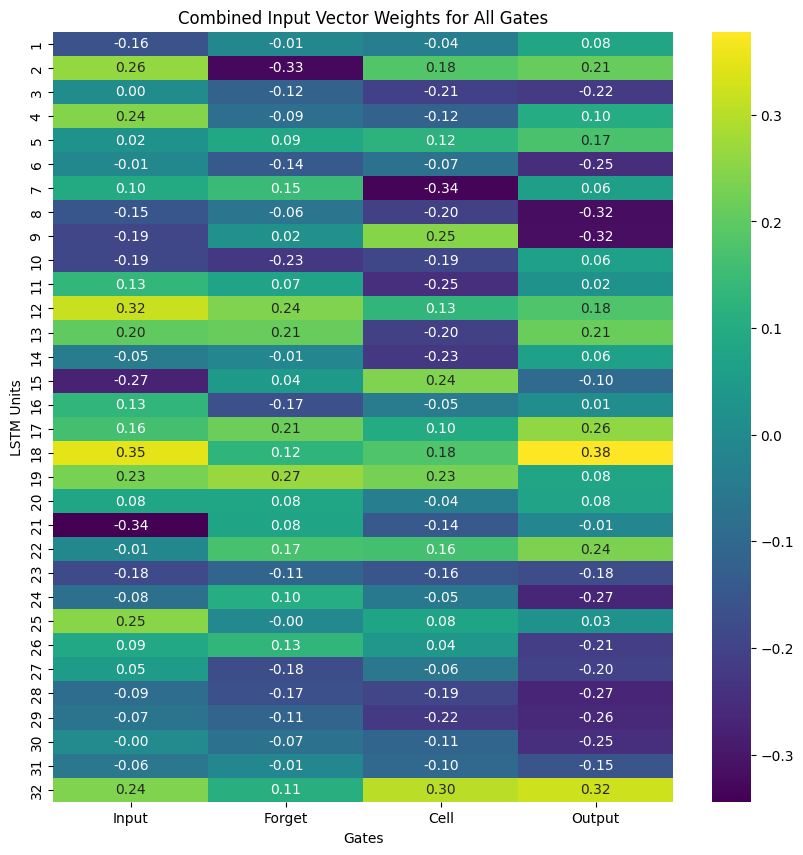

In [ ]:
# Create heatmap for Input Feature Weights
plt.figure(figsize=(10, 10))  # Adjust figure size as needed
sns.heatmap((W_x_combined.T), annot=True, cmap='viridis', fmt=".2f",
            xticklabels=['Input', 'Forget', 'Cell', 'Output'],
            yticklabels=np.arange(1, num_units + 1),  # Assuming num_units is defined
            )
plt.title('Combined Input Vector Weights for All Gates')
plt.xlabel('Gates')
plt.ylabel('LSTM Units')
# plt.xticks(np.arange(0, W_x_combined.shape[0]), ['Input', 'Forget', 'Cell', 'Output'])
plt.show()

Which Cells Output Gate Weight is high for certain Feature. Has potentially high correlation with it.

(7500,)
(7500,)
(7500, 6)


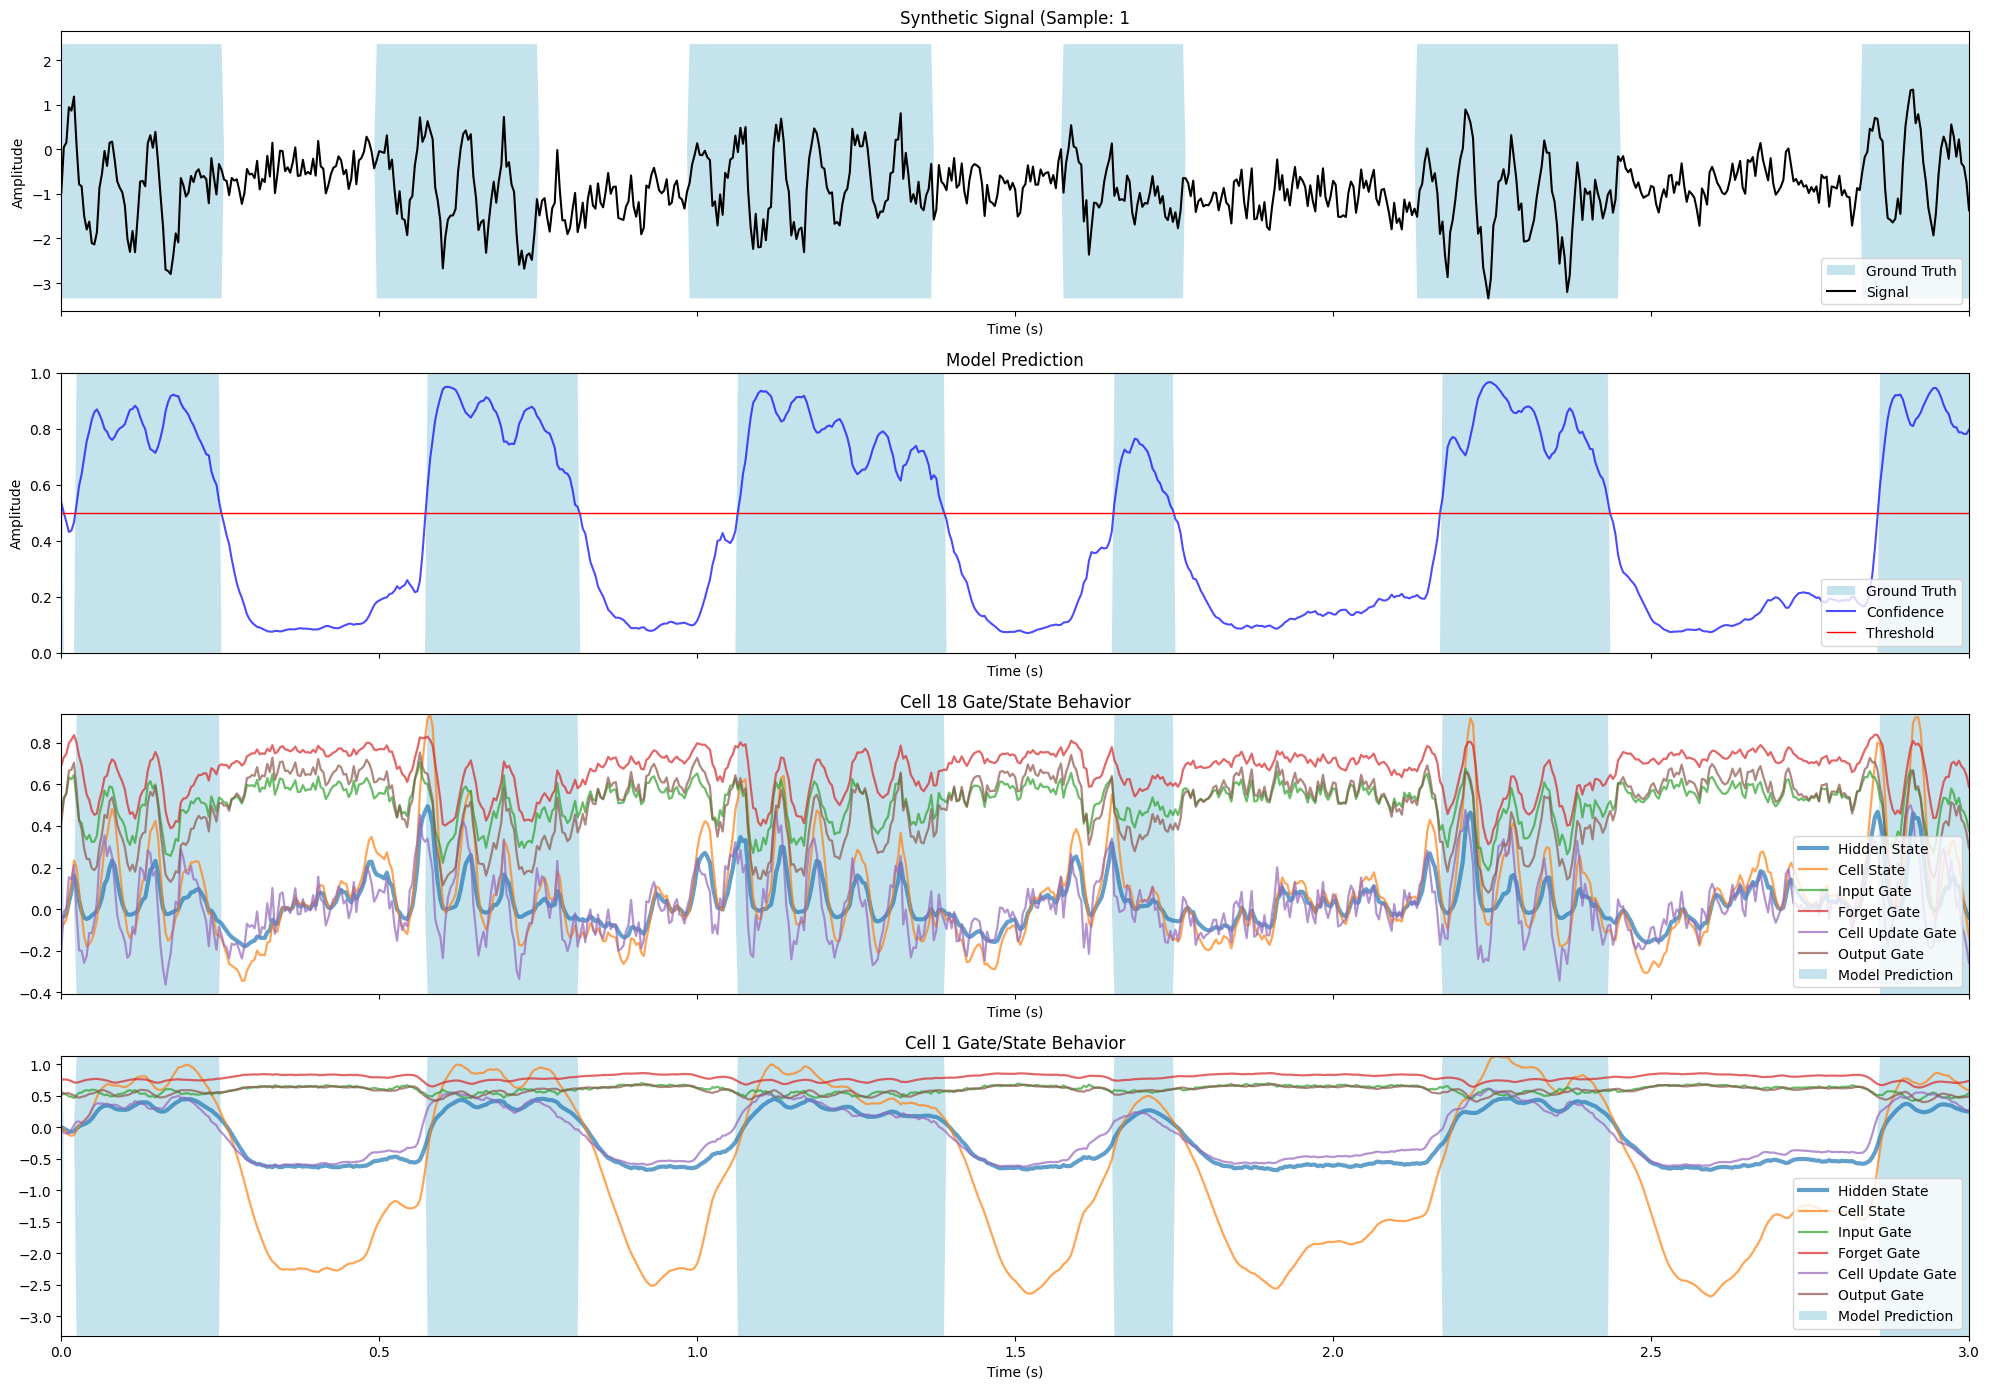

In [ ]:
sample = 2
cell_id = 17
cell_id2 = 0
label_sample = y_test[sample].flatten()
signal_sample = X_test_scaled[sample,:,0].flatten()
wavelet_sample = cell_states[sample,:,:1]
output_prediction_sample = output_prediction[sample, :, 0].flatten()
wavelet_sample = np.stack([hidden_states[sample,:,cell_id],
                          cell_states[sample,:,cell_id],
                          input_gates[sample,:,cell_id],
                          forget_gates[sample,:,cell_id],
                          cell_update_gates[sample,:,cell_id],
                          output_gates[sample,:,cell_id]], axis=1)

cell_sample = np.stack([hidden_states[sample,:,cell_id2],
                          cell_states[sample,:,cell_id2],
                          input_gates[sample,:,cell_id2],
                          forget_gates[sample,:,cell_id2],
                          cell_update_gates[sample,:,cell_id2],
                          output_gates[sample,:,cell_id2]], axis=1)


print(label_sample.shape)
print(signal_sample.shape)
print(wavelet_sample.shape)

custom_labels = ['Hidden State', 'Cell State', 'Input Gate', 'Forget Gate', 'Cell Update Gate', 'Output Gate']



visualize_feature_data(label_sample, signal_sample, wavelet_sample, cell_sample, output_prediction_sample, duration=30, time_window=(0, 3), custom_feature_labels=custom_labels)


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 7500, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_analyis_layer (RNN)  │ [(None, 7500, 32),     │          4,352 │ input_layer[0][0]      │
│                           │ (None, 32), (None,     │                │                        │
│                           │ 32)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 7500, 32)       │              0 │ lstm_analyis_layer[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 7500, 1)        │             33 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 7500, 0)        │              0 │ lstm_analyis_layer[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 7500, 0)        │              0 │ lstm_analyis_layer[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 7500, 0)        │              0 │ lstm_analyis_layer[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 7500, 0)        │              0 │ lstm_analyis_layer[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 7500, 0)        │              0 │ lstm_analyis_layer[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_6 (GetItem)      │ (None, 7500, 0)        │              0 │ lstm_analyis_layer[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 13,157 (51.40 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,772 (34.27 KB)

In [ ]:
def analyze_cell_reliance(model):
    """
    Analyzes the reliance of LSTM cells on input versus saved data.

    Args:
        model: The trained Keras LSTM model.
        num_units: The number of LSTM units in the layer.

    Returns:
        tuple: A tuple containing two arrays:
            - combined_Wh: An array of combined W_h weights for each cell.
            - combined_Wx: An array of combined W_x weights for each cell.
    """

    # Get the LSTM layer
    lstm_layer = model.get_layer('lstm_analyis_layer')  # Assuming your LSTM layer is named 'rnn'
    num_units = lstm_layer.cell.units
    # Get the weights
    weights = lstm_layer.get_weights()
    kernel = weights[0]
    recurrent_kernel = weights[1]

    print("Kernel", kernel.shape)
    print("Recurrent Kernel", recurrent_kernel.shape)

    # Initialize arrays to store combined weights
    combined_Wh = np.zeros(num_units)
    combined_Wx = np.zeros(num_units)

    # Calculate combined weights for each cell
    for cell_index in range(num_units):
        # Combined W_h weights (sum of absolute values)
        Wh_weights = [
            recurrent_kernel[:, cell_index],  # W_hi
            recurrent_kernel[:, cell_index + num_units],  # W_hf
            recurrent_kernel[:, cell_index + 2 * num_units],  # W_hg
            recurrent_kernel[:, cell_index + 3 * num_units]  # W_ho
        ]
        combined_Wh[cell_index] = np.sum(np.abs(np.concatenate(Wh_weights)))

        # Combined W_x weights (sum of absolute values)
        Wx_weights = [
            kernel[:, cell_index],  # W_hi
            kernel[:, cell_index + num_units],  # W_hf
            kernel[:, cell_index + 2 * num_units],  # W_hg
            kernel[:, cell_index + 3 * num_units]  # W_ho
        ]
        combined_Wx[cell_index] = np.sum(np.abs(np.concatenate(Wx_weights)))

    return combined_Wh, combined_Wx

# --- Usage ---
combined_Wh, combined_Wx = analyze_cell_reliance(model)

print(combined_Wh)
# Print or visualize the results
for cell_index in range(num_units):
    print(f"Cell {cell_index + 1}:")
    print(f"  Combined W_h: {combined_Wh[cell_index]:.4f}")
    print(f"  Combined W_x: {combined_Wx[cell_index]:.4f}")
    print(f"  Reliance: {'Hidden State' if combined_Wh[cell_index] > combined_Wx[cell_index] else 'Input'}")
    print()

# You can further visualize the results using bar plots or other visualizations.

Kernel (1, 128)
Recurrent Kernel (32, 128)
[11.47106647 11.24938488 12.52560711  9.64268875 12.3280735  13.01903725
 12.04898357 12.04712296 11.13870239 11.95032692 12.12210751 12.1876955
 11.65589523 10.83847809 10.6476965   8.96376133 10.17019653 14.66705704
 12.58500099 10.04238987 13.67000771 13.48675442 10.51572418 13.7558918
 11.08540726 11.27504349 13.50802612 11.5310421  12.31706619 10.00773239
  9.56763363 13.20397377]
Cell 1:
  Combined W_h: 11.4711
  Combined W_x: 0.2900
  Reliance: Hidden State

Cell 2:
  Combined W_h: 11.2494
  Combined W_x: 0.9787
  Reliance: Hidden State

Cell 3:
  Combined W_h: 12.5256
  Combined W_x: 0.5499
  Reliance: Hidden State

Cell 4:
  Combined W_h: 9.6427
  Combined W_x: 0.5468
  Reliance: Hidden State

Cell 5:
  Combined W_h: 12.3281
  Combined W_x: 0.4006
  Reliance: Hidden State

Cell 6:
  Combined W_h: 13.0190
  Combined W_x: 0.4720
  Reliance: Hidden State

Cell 7:
  Combined W_h: 12.0490
  Combined W_x: 0.6392
  Reliance: Hidden State

Ce